### Statistical testing for ensemble simulations

In traditional COBRA simulations with a single model, most simulations result in a single quantity of interest, thus statistical comparisons usually don't make sense. For example, when simulating growth in two different media conditions, a single model can only output a single predicted growth rate for each condition.

When accounting for uncertainty in model structure using an ensemble, these simulations generate a distribution rather than a single value. Because we are no longer comparing two individual values, proper interpretation requires statistical assessment of the distributions our ensemble simulations generate. In this example, we demonstrate this concept and one statistical option for univariate comparisons (e.g. comparisons between two conditions).

First, let's load an ensemble for *Staphylococcus aureus* and the recipe for biolog growth media, which we'll use to simulate growth in single carbon source media.

In [1]:
import medusa
from medusa.test import create_test_ensemble

ensemble = create_test_ensemble("Staphylococcus aureus")

In [2]:
import pandas as pd
biolog_base = pd.read_csv("../medusa/test/data/biolog_base_composition.csv", sep=",")
biolog_base

,Name,ID
0,H2O,cpd00001_e
1,O2,cpd00007_e
2,Phosphate,cpd00009_e
3,CO2,cpd00011_e
4,NH3,cpd00013_e
5,Mn2+,cpd00030_e
6,Zn2+,cpd00034_e
7,Sulfate,cpd00048_e
8,Cu2+,cpd00058_e
9,Ca2+,cpd00063_e


In [3]:
# convert the biolog base to a dictionary, which we can use to set ensemble.base_model.medium directly.
biolog_base = {'EX_'+component:1000 for component in biolog_base['ID']}

# Double check that the objective is set to the biomass reaction.
# For this model, 'bio1' is the id of the biomass reaction.
ensemble.base_model.objective = 'bio1'

Let's simulate growth on two different carbon sources, D-glucose (metabolite id: cpd00027) and maltose (metabolite id: cpd00179).

In [4]:
from medusa.flux_analysis import flux_balance

carbon_sources = ["EX_cpd00027_e","EX_cpd00179_e"]

fluxes = {}
for carbon_source in carbon_sources:
    biolog_base[carbon_source] = 10
    ensemble.base_model.medium = biolog_base
    fluxes[carbon_source] = flux_balance.optimize_ensemble(ensemble,return_flux='bio1', num_processes = 4)
    biolog_base[carbon_source] = 0

Now let's visualize the distributions of predicted flux through biomass using matplotlib. We'll generate a histogram for each condition, and plot the mean using a vertical line:

In [5]:
import matplotlib.pylab as plt
import numpy as np

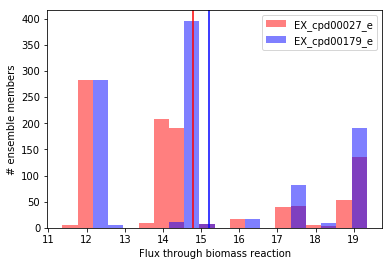

In [6]:
fig, ax = plt.subplots()
bins=np.histogram(np.hstack((fluxes[carbon_sources[0]]['bio1'],fluxes[carbon_sources[1]]['bio1'])), bins=20)[1]
plt.hist(fluxes[carbon_sources[0]]['bio1'],
         bins = bins,
         label=carbon_sources[0],
         color = "red",
         alpha = 0.5)
plt.hist(fluxes[carbon_sources[1]]['bio1'],
         bins = bins,
         label=carbon_sources[1], 
         color = "blue", 
         alpha = 0.5)
plt.axvline(x=fluxes[carbon_sources[0]]['bio1'].mean(), c = 'red')
plt.axvline(x=fluxes[carbon_sources[1]]['bio1'].mean(), c = 'blue')
ax.set_ylabel('# ensemble members')
ax.set_xlabel('Flux through biomass reaction')
ax.legend()
plt.show()

Visually, we can see the mean for D-glucose (cpd00027) is slightly lower than for maltose (cpd00179). To evaluate this statistically, we'll use the Wilcoxon signed-rank test (implemented in SciPy), which tests the null hypothesis that the difference between paired samples (e.g. growth in D-glucose minus growth in maltose for each ensemble member) is symmetrically distributed around zero. Here, we choose a statistical test meant for paired data because each simulation result in one media condition has a related simulation result in the other condition which was generated using the same ensemble member. The Wilcoxon signed-rank test is suitable for paired univariate comparisons regardless of the distribution of data (e.g. when data are non-normally distributed, replace a paired *t*-test with the Wolcoxon signed-rank test).

In [7]:
from scipy.stats import wilcoxon
cond1 = fluxes[carbon_sources[0]].copy()
cond2 = fluxes[carbon_sources[1]].copy()
cond1.columns = [carbon_sources[0]]
cond2.columns = [carbon_sources[1]]
both_conditions = pd.concat([cond1,cond2], axis = 1, join_axes = [cond1.index])

wilcoxon(x=both_conditions[carbon_sources[0]],y=both_conditions[carbon_sources[1]])

WilcoxonResult(statistic=0.0, pvalue=3.3257599356529824e-165)

The *p* value from the test is well below any reasonable threshold, so we can claim that the predicted flux through biomass with maltose as the sole carbon source is higher than flux through biomass with D-glucose as the sole carbon source.